In [1]:
import torch

In [2]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
import torchvision
import pathlib
import numpy as np
import cv2
import os
import random
import glob
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
transformer = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_path = r'G:\CSE_465\project\project\Dataset'
tests_path = r'G:\CSE_465\project\project\test'

train_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform = transformer),
    batch_size = 100,shuffle= True
)

test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(tests_path, transform = transformer),
    batch_size = 100,shuffle= True
)

In [6]:
classes = ['Bear','Camel','Cat','Dear','Dog','Elephant','Fish','Hamstar','Rakun','Tiger']

torch.Size([100, 3, 64, 64]) torch.Size([100])


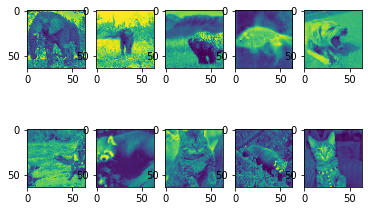

10


In [7]:
example = iter(train_dataloader)
samples, labels = example.next()
print(samples.shape, labels.shape)
for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(samples[i][0])
plt.show()
print(len(train_dataloader))

In [23]:
class FeedForward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, numclasses):
        super(FeedForward, self).__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.relu1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(hidden_size,numclasses)
#         self.relu2 = torch.nn.ReLU()
#         self.l3 = torch.nn.Linear(100,numclasses)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
#         out = self.relu2(out)
#         out = self.l3(out)
        return out


In [70]:
model = FeedForward((3*64*64), 50, 10)
model = model.to(device)
epoch = 100

loss_arr = []

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_total_stapes = len(train_dataloader)
for  epochs in range(epoch):
    model.train()
    train_loss = 0.0
    train_accuricy = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.reshape(-1, (3*64*64)).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*10
        
        _,prediction = torch.max(outputs.data,1)
        
        train_accuricy+= int(torch.sum(prediction==labels.data))
        
    train_accuricy = train_accuricy/1000
    train_loss = train_loss/1000
    loss_arr.append(train_loss)
    
    model.eval()
    test_accuricy= 0.0
    
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.reshape(-1, (3*64*64)).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _,prediction = torch.max(outputs.data,1)
        
        test_accuricy+= int(torch.sum(prediction==labels.data))
        
    test_accuricy = test_accuricy/500
    print(f'Epoch {epochs+1} / {epoch} , Train Loss: {train_loss:.4f},  Train Accuricy:  {train_accuricy:.4f},   Test Accuricy:  {test_accuricy:.4f}' )   



Epoch 1 / 100 , Train Loss: 0.2730,  Train Accuricy:  0.1110,   Test Accuricy:  0.1000
Epoch 2 / 100 , Train Loss: 0.2304,  Train Accuricy:  0.1160,   Test Accuricy:  0.1360
Epoch 3 / 100 , Train Loss: 0.2248,  Train Accuricy:  0.1900,   Test Accuricy:  0.1740
Epoch 4 / 100 , Train Loss: 0.2193,  Train Accuricy:  0.2210,   Test Accuricy:  0.1760
Epoch 5 / 100 , Train Loss: 0.2154,  Train Accuricy:  0.2260,   Test Accuricy:  0.1980
Epoch 6 / 100 , Train Loss: 0.2170,  Train Accuricy:  0.2160,   Test Accuricy:  0.1860
Epoch 7 / 100 , Train Loss: 0.2104,  Train Accuricy:  0.2470,   Test Accuricy:  0.1840
Epoch 8 / 100 , Train Loss: 0.2065,  Train Accuricy:  0.2770,   Test Accuricy:  0.1800
Epoch 9 / 100 , Train Loss: 0.2031,  Train Accuricy:  0.2690,   Test Accuricy:  0.1900
Epoch 10 / 100 , Train Loss: 0.2002,  Train Accuricy:  0.3120,   Test Accuricy:  0.1900
Epoch 11 / 100 , Train Loss: 0.1964,  Train Accuricy:  0.3250,   Test Accuricy:  0.2400
Epoch 12 / 100 , Train Loss: 0.1909,  Tra

Epoch 95 / 100 , Train Loss: 0.0522,  Train Accuricy:  0.9250,   Test Accuricy:  0.2080
Epoch 96 / 100 , Train Loss: 0.0514,  Train Accuricy:  0.9130,   Test Accuricy:  0.2100
Epoch 97 / 100 , Train Loss: 0.0506,  Train Accuricy:  0.9250,   Test Accuricy:  0.2000
Epoch 98 / 100 , Train Loss: 0.0490,  Train Accuricy:  0.9320,   Test Accuricy:  0.2140
Epoch 99 / 100 , Train Loss: 0.0501,  Train Accuricy:  0.9160,   Test Accuricy:  0.2140
Epoch 100 / 100 , Train Loss: 0.0522,  Train Accuricy:  0.8940,   Test Accuricy:  0.2140


In [80]:
class CNN(torch.nn.Module):
    def __init__(self, numclasses):
        super(CNN, self).__init__()
        
        self.con1 = torch.nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride= 1)
        
        self.con2 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU() 
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride= 1)
        
        self.con3 = torch.nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=3, stride= 1)
        
        self.l1 = torch.nn.Linear((32*58*58), 50)
        self.relu4 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(50,numclasses)
        
    def forward(self, x):
        out = self.con1(x)
        out = self.relu1(out)
        out = self.pool1(out)
#         print(out.shape)
        out = self.con2(out)
        out = self.relu2(out)
        out = self.pool2(out)
#         print(out.shape)
        out = self.con3(out)
        out = self.relu3(out)
        out = self.pool3(out)
        
#         print(out.shape)
        out = out.view(-1, 32*58*58)
        
        out = self.l1(out)
        out = self.relu4(out)
        out = self.l2(out)
        
        return out
        

In [85]:
modelCNN = CNN(10)
modelCNN = modelCNN.to(device)
epoch = 50

loss_arr_CNN = []

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.001)

n_total_stapes = len(train_dataloader)
for  epochs in range(epoch):
    modelCNN.train()
    train_loss = 0.0
    train_accuricy = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = modelCNN(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*10
        
        _,prediction = torch.max(outputs.data,1)
        
        train_accuricy+= int(torch.sum(prediction==labels.data))
        
    train_accuricy = train_accuricy/1000
    train_loss = train_loss/1000
    loss_arr_CNN.append(train_loss)
    
    modelCNN.eval()
    test_accuricy= 0.0
    
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = modelCNN(images)
        _,prediction = torch.max(outputs.data,1)
        
        test_accuricy+= int(torch.sum(prediction==labels.data))
        
    test_accuricy = test_accuricy/500
    print(f'Epoch {epochs+1} / {epoch} , Train Loss: {train_loss:.4f},  Train Accuricy:  {train_accuricy:.4f},   Test Accuricy:  {test_accuricy:.4f}' )   



Epoch 1 / 50 , Train Loss: 0.2369,  Train Accuricy:  0.0960,   Test Accuricy:  0.1260
Epoch 2 / 50 , Train Loss: 0.2287,  Train Accuricy:  0.1240,   Test Accuricy:  0.1800
Epoch 3 / 50 , Train Loss: 0.2206,  Train Accuricy:  0.1850,   Test Accuricy:  0.1920
Epoch 4 / 50 , Train Loss: 0.2065,  Train Accuricy:  0.2680,   Test Accuricy:  0.2500
Epoch 5 / 50 , Train Loss: 0.1917,  Train Accuricy:  0.3110,   Test Accuricy:  0.2800
Epoch 6 / 50 , Train Loss: 0.1784,  Train Accuricy:  0.3560,   Test Accuricy:  0.3220
Epoch 7 / 50 , Train Loss: 0.1701,  Train Accuricy:  0.4020,   Test Accuricy:  0.3180
Epoch 8 / 50 , Train Loss: 0.1590,  Train Accuricy:  0.4350,   Test Accuricy:  0.3520
Epoch 9 / 50 , Train Loss: 0.1465,  Train Accuricy:  0.4840,   Test Accuricy:  0.3560
Epoch 10 / 50 , Train Loss: 0.1332,  Train Accuricy:  0.5470,   Test Accuricy:  0.3480
Epoch 11 / 50 , Train Loss: 0.1236,  Train Accuricy:  0.5720,   Test Accuricy:  0.3580
Epoch 12 / 50 , Train Loss: 0.1101,  Train Accuricy:

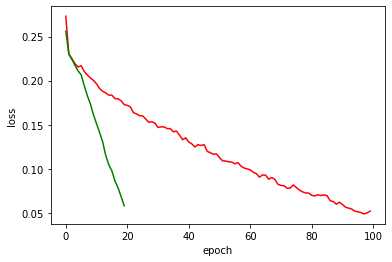

In [82]:
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.plot(np.array(loss_arr), 'red')
plt.plot(np.array(loss_arr_CNN), 'green')

In [93]:
def Prediction(image_path , transformer):
    image = Image.open(image_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.reshape(-1,(3*64*64))
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = model(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred


In [86]:
def PredictionCNN(image_path , transformer):
    image = Image.open(image_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = modelCNN(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred


In [91]:
PredictionCNN("G:/CSE_465/project/project/n02437312_129.JPEG", transformer)

'Camel'

In [94]:
Prediction("G:/CSE_465/project/project/n02437312_129.JPEG", transformer)

'Dear'

In [21]:
# image = Image.open("G:/CSE_465/project/project/test/n02437312_292.JPEG")
# image = transformer(image)
# image = image.reshape(-1,(3*64*64))
# print(image.shape)

In [43]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
